# Chemistry

In [19]:
from molgraph import chemistry

import tensorflow as tf

import matplotlib.pyplot as plt

In [20]:
# Convert SMILES representation of molecule to an RDKit molecule
rdkit_mol = chemistry.molecule_from_string(
    'OCC1OC(C(C1O)O)n1cnc2c1ncnc2N')

print(type(rdkit_mol))

<class 'rdkit.Chem.rdchem.Mol'>


### `chemistry.features` (level 1)

In [24]:
# Obtain RDKit atom and bond via the RDKit API
atom = rdkit_mol.GetAtoms()[0]
bond = rdkit_mol.GetBonds()[0]

symbol_feature = chemistry.features.Symbol()
bondtype_feature = chemistry.features.BondType()

print('Symbol:  ', symbol_feature(atom))
print('BondType:', bondtype_feature(bond))




Symbol:   O
BondType: SINGLE


#### Arguments of a `chemistry.Feature`

- `allowable_set` specifies what features should be considered
- `oov_size` specifies the number of bins alloted to "out-of-vocabulary" features (based on `allowable_set`) 
- `ordinal` specifies if encoding should be ordinal or not (nominal)

Importantly, the arguments above will only take effect when wrapped in a `chemistry.Encoding`, which occur automatically inside a `chemistry.Featurizer` or `chemistry.Tokenizer`.

In [25]:
print(chemistry.features.BondType())
print(chemistry.features.BondType(allowable_set=['SINGLE', 'DOUBLE'], oov_size=1, ordinal=False))

BondType(allowable_set={'DOUBLE', 'TRIPLE', 'AROMATIC', 'SINGLE'}, ordinal=False, oov_size=0)
BondType(allowable_set=['SINGLE', 'DOUBLE'], ordinal=False, oov_size=1)


###  `chemistry.Featurizer` (level 2)

A `chemistry.Featurizer` (or `chemistry.Tokenizer`) can be built from a list of `chemistry.Feature`s. Note: if `ordinal=False` (default), `allowable_set` will be sorted internally via `sort()`. 

In [26]:
atom_encoder = chemistry.Featurizer([
    chemistry.features.Symbol(['C', 'N', 'O'], oov_size=1),
    chemistry.features.Hybridization(['SP', 'SP2', 'SP3'], oov_size=1)
])

print('Symbol:       ', atom.GetSymbol())
print('Hybridization:', atom.GetHybridization().name)

# first and fifth bin is alloted to OOVs
print(atom_encoder(atom))

Symbol:        O
Hybridization: SP3
[0. 0. 0. 1. 0. 0. 0. 1.]


#### Create a custom `chemistry.Feature`

In [27]:
class AtomMass(chemistry.Feature):
    def __call__(self, x):
        mass = x.GetMass()
        if mass < 5:
            return 'x<5'
        elif mass < 40:
            return '5<x<40'
        else:
            return '40<x'

featurizer = chemistry.Featurizer([
    AtomMass({'x<5', '5<x<40', '40<x'}), 
    chemistry.features.Symbol({'C', 'N'})
])
        
print('AtomMass:', atom.GetMass())
print('Symbol:  ', atom.GetSymbol())
print(featurizer(atom))

AtomMass: 15.999
Symbol:   O
[0. 1. 0. 0. 0.]


### `chemistry.MolecularGraphEncoder` (level 3)

`chemistry.MolecularGraphEncoder` encodes inputted molecule(s) as molecular graphs, namely as a `GraphTensor`.


Below a single molecule is encoded as a `GraphTensor`

In [29]:
atom_encoder = chemistry.Featurizer([
    chemistry.features.Symbol(allowable_set={'C', 'N', 'O'})
])
bond_encoder = chemistry.Featurizer([
    chemistry.features.BondType(allowable_set={'SINGLE', 'DOUBLE'})
])

mol_encoder = chemistry.MolecularGraphEncoder(
    atom_encoder=atom_encoder,                                    # not default, required
    bond_encoder=bond_encoder,                                    # not default, optional
    positional_encoding_dim=16,                                   # default
    self_loops=False,                                             # default
    molecule_from_string_fn=chemistry.molecule_from_string        # default
)

print(mol_encoder(rdkit_mol))

GraphTensor(
  sizes=<tf.Tensor: shape=(), dtype=int64>,
  node_feature=<tf.Tensor: shape=(19, 3), dtype=float32>,
  edge_src=<tf.Tensor: shape=(42,), dtype=int32>,
  edge_dst=<tf.Tensor: shape=(42,), dtype=int32>,
  edge_feature=<tf.Tensor: shape=(42, 2), dtype=float32>,
  node_position=<tf.Tensor: shape=(19, 16), dtype=float32>)


Here, a list of molecules are encoded as a `GraphTensor`

In [32]:
smiles = [
    'OCC1OC(C(C1O)O)n1cnc2c1ncnc2N',
    'C(C(=O)O)N',
    'C1=CC(=CC=C1CC(C(=O)O)N)O'
]
# Uses multiprocessing by default
graph_tensor = mol_encoder(smiles, processes=8)
print(graph_tensor)

GraphTensor(
  sizes=<tf.Tensor: shape=(3,), dtype=int64>,
  node_feature=<tf.Tensor: shape=(37, 3), dtype=float32>,
  edge_src=<tf.Tensor: shape=(76,), dtype=int32>,
  edge_dst=<tf.Tensor: shape=(76,), dtype=int32>,
  edge_feature=<tf.Tensor: shape=(76, 2), dtype=float32>,
  node_position=<tf.Tensor: shape=(37, 16), dtype=float32>)


#### Inspect generated `GraphTensor`

In [33]:
print('node_feature:', graph_tensor.node_feature, end='\n\n')
print('edge_feature:', graph_tensor.edge_feature, end='\n\n')
print('edge_dst:', graph_tensor.edge_dst, end='\n\n')
print('edge_src:', graph_tensor.edge_src, end='\n\n')

node_feature: tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(37, 3), dtype=float32)

edge_feature: tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 

#### Extract the second subgraph (glycine)

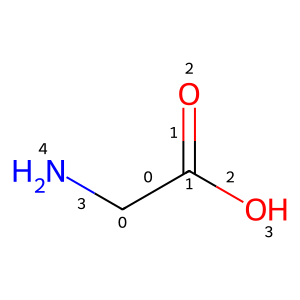

In [35]:
from molgraph.chemistry import vis

index = 1

# visualize the second molecule of the GraphTensor as reference
vis.visualize_molecule(
    molecule=molecules[index], 
    atom_index=True, 
    bond_index=True
)

In [36]:
print(graph_tensor[index], end='\n\n')
print('node_feature:', graph_tensor[index].node_feature, end='\n\n')
print('edge_feature:', graph_tensor[index].edge_feature, end='\n\n')
print('edge_dst:', graph_tensor[index].edge_dst, end='\n\n')
print('edge_src:', graph_tensor[index].edge_src, end='\n\n')

GraphTensor(
  sizes=<tf.Tensor: shape=(), dtype=int64>,
  node_feature=<tf.Tensor: shape=(5, 3), dtype=float32>,
  edge_src=<tf.Tensor: shape=(8,), dtype=int32>,
  edge_dst=<tf.Tensor: shape=(8,), dtype=int32>,
  edge_feature=<tf.Tensor: shape=(8, 2), dtype=float32>,
  node_position=<tf.Tensor: shape=(5, 16), dtype=float32>)

node_feature: tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)

edge_feature: tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]], shape=(8, 2), dtype=float32)

edge_dst: tf.Tensor([1 4 0 2 3 1 1 0], shape=(8,), dtype=int32)

edge_src: tf.Tensor([0 0 1 1 1 2 3 4], shape=(8,), dtype=int32)



#### Separate `GraphTensor` (its subgraphs) into separate rows

In [37]:
graph_tensor = graph_tensor.separate()
print(graph_tensor, end='\n\n')
print('node_feature:', graph_tensor.node_feature, end='\n\n')
print('edge_feature:', graph_tensor.edge_feature, end='\n\n')
print('edge_dst:', graph_tensor.edge_dst, end='\n\n')
print('edge_src:', graph_tensor.edge_src, end='\n\n')
print('graph_indicator:', graph_tensor.graph_indicator)

GraphTensor(
  sizes=<tf.Tensor: shape=(3,), dtype=int64>,
  node_feature=<tf.RaggedTensor: shape=(3, None, 3), dtype=float32, ragged_rank=1>,
  edge_src=<tf.RaggedTensor: shape=(3, None), dtype=int32, ragged_rank=1>,
  edge_dst=<tf.RaggedTensor: shape=(3, None), dtype=int32, ragged_rank=1>,
  edge_feature=<tf.RaggedTensor: shape=(3, None, 2), dtype=float32, ragged_rank=1>,
  node_position=<tf.RaggedTensor: shape=(3, None, 16), dtype=float32, ragged_rank=1>)

node_feature: <tf.RaggedTensor [[[0.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 0.0, 1.0],
  [0.0, 0.0, 1.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0],
  [1.0, 0.0, 0.0],
  [0.0, 1.0, 0.0]], [[1.0, 0.0, 0.0],
                     [1.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0],
                     [0.0, 0.0, 1.0],
           

#### Merge `GraphTensor` (its subgraphs) into a single disjoint graph

In [38]:
graph_tensor = graph_tensor.merge()
print(graph_tensor, end='\n\n')
print('node_feature:', graph_tensor.node_feature, end='\n\n')
print('edge_feature:', graph_tensor.edge_feature, end='\n\n')
print('edge_dst:', graph_tensor.edge_dst, end='\n\n')
print('edge_src:', graph_tensor.edge_src, end='\n\n')

GraphTensor(
  sizes=<tf.Tensor: shape=(3,), dtype=int64>,
  node_feature=<tf.Tensor: shape=(37, 3), dtype=float32>,
  edge_src=<tf.Tensor: shape=(76,), dtype=int32>,
  edge_dst=<tf.Tensor: shape=(76,), dtype=int32>,
  edge_feature=<tf.Tensor: shape=(76, 2), dtype=float32>,
  node_position=<tf.Tensor: shape=(37, 16), dtype=float32>)

node_feature: tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(37, 3), dtype=float32)

edge_feature: tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [